# main code for training and pre-processing

In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler
from torch.optim import AdamW
import pandas as pdf
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import nltk
from tqdm.auto import tqdm

import torch.nn.functional as F

nltk.download('punkt')
nltk.download('punkt_tab')

/home/mamdouh/anaconda3/envs/test/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[nltk_data] Downloading package punkt to /home/mamdouh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mamdouh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
import torch
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:

def load_data(en_file, tr_file):
    en_file = "data_directories/final_data/" + en_file
    tr_file = "data_directories/final_data/" + tr_file
    # en_file = "archive/" + en_file
    # tr_file = "archive/" + tr_file
    with open(en_file, 'r', encoding='utf-8') as file:
        en_texts = file.read().strip().split('\n')
    with open(tr_file, 'r', encoding='utf-8') as file:
        tr_texts = file.read().strip().split('\n')
    return pd.DataFrame({'en': en_texts, 'tr': tr_texts})

# train_data = load_data('english_train_paraphrased.txt', "akkadian_train_paraphrased.txt")
# train_data = load_data('new_combined_data_english.txt', "new_combined_data_akkadian.txt")
train_data = load_data("english_train.txt", "akkadian_train.txt")
val_data = load_data("english_val.txt", "akkadian_val.txt")
test_data = load_data("english_test.txt", "akkadian_test.txt")

## Exploratory Data Analysis

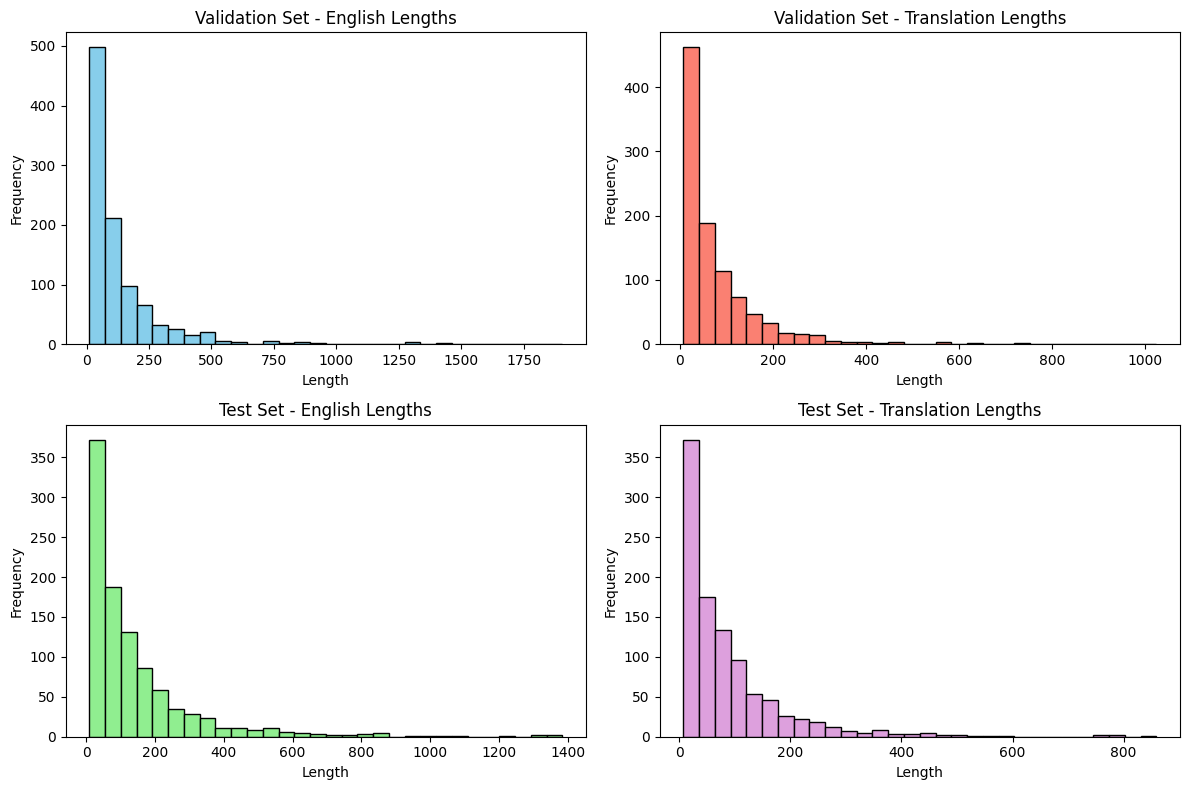

In [43]:
import matplotlib.pyplot as plt

# Compute lengths
len_val = [(len(row['en']), len(row['tr'])) for idx, row in val_data.iterrows()]
len_test = [(len(row['en']), len(row['tr'])) for idx, row in test_data.iterrows()]

# Split into separate lists
val_en_lens = [en for en, tr in len_val]
val_tr_lens = [tr for en, tr in len_val]
test_en_lens = [en for en, tr in len_test]
test_tr_lens = [tr for en, tr in len_test]

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Validation set
axs[0, 0].hist(val_en_lens, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Validation Set - English Lengths')
axs[0, 0].set_xlabel('Length')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(val_tr_lens, bins=30, color='salmon', edgecolor='black')
axs[0, 1].set_title('Validation Set - Translation Lengths')
axs[0, 1].set_xlabel('Length')
axs[0, 1].set_ylabel('Frequency')

# Test set
axs[1, 0].hist(test_en_lens, bins=30, color='lightgreen', edgecolor='black')
axs[1, 0].set_title('Test Set - English Lengths')
axs[1, 0].set_xlabel('Length')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(test_tr_lens, bins=30, color='plum', edgecolor='black')
axs[1, 1].set_title('Test Set - Translation Lengths')
axs[1, 1].set_xlabel('Length')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [44]:
from scipy.stats import ks_2samp

# Kolmogorov-Smirnov test between validation and test sets
ks_en = ks_2samp(val_en_lens, test_en_lens)
ks_tr = ks_2samp(val_tr_lens, test_tr_lens)

# Display results
print("Kolmogorov-Smirnov Test Results:")
print("-" * 40)
print(f"EN lengths - D-statistic: {ks_en.statistic:.4f}, p-value: {ks_en.pvalue:.4f}")
if ks_en.pvalue < 0.05:
    print("🟥 Significant difference in EN distributions (p < 0.05)")
else:
    print("🟩 No significant difference in EN distributions")

print("-" * 40)
print(f"TR lengths - D-statistic: {ks_tr.statistic:.4f}, p-value: {ks_tr.pvalue:.4f}")
if ks_tr.pvalue < 0.05:
    print("🟥 Significant difference in TR distributions (p < 0.05)")
else:
    print("🟩 No significant difference in TR distributions")


Kolmogorov-Smirnov Test Results:
----------------------------------------
EN lengths - D-statistic: 0.0520, p-value: 0.1339
🟩 No significant difference in EN distributions
----------------------------------------
TR lengths - D-statistic: 0.0630, p-value: 0.0378
🟥 Significant difference in TR distributions (p < 0.05)


### In case there is a difference in distrubtions, we resplit the data

In [18]:
import pandas as pd
from sklearn.utils import shuffle

# Combine datasets
combined_data = pd.concat([val_data, test_data], ignore_index=True)

# Shuffle the combined data
combined_data = shuffle(combined_data, random_state=42).reset_index(drop=True)

# Split evenly
half = len(combined_data) // 2
new_val_data = combined_data.iloc[:half].reset_index(drop=True)
new_test_data = combined_data.iloc[half:].reset_index(drop=True)

print(f"New validation size: {len(new_val_data)}")
print(f"New test size: {len(new_test_data)}")

val_data = new_val_data
test_data = new_test_data

New validation size: 1000
New test size: 1000


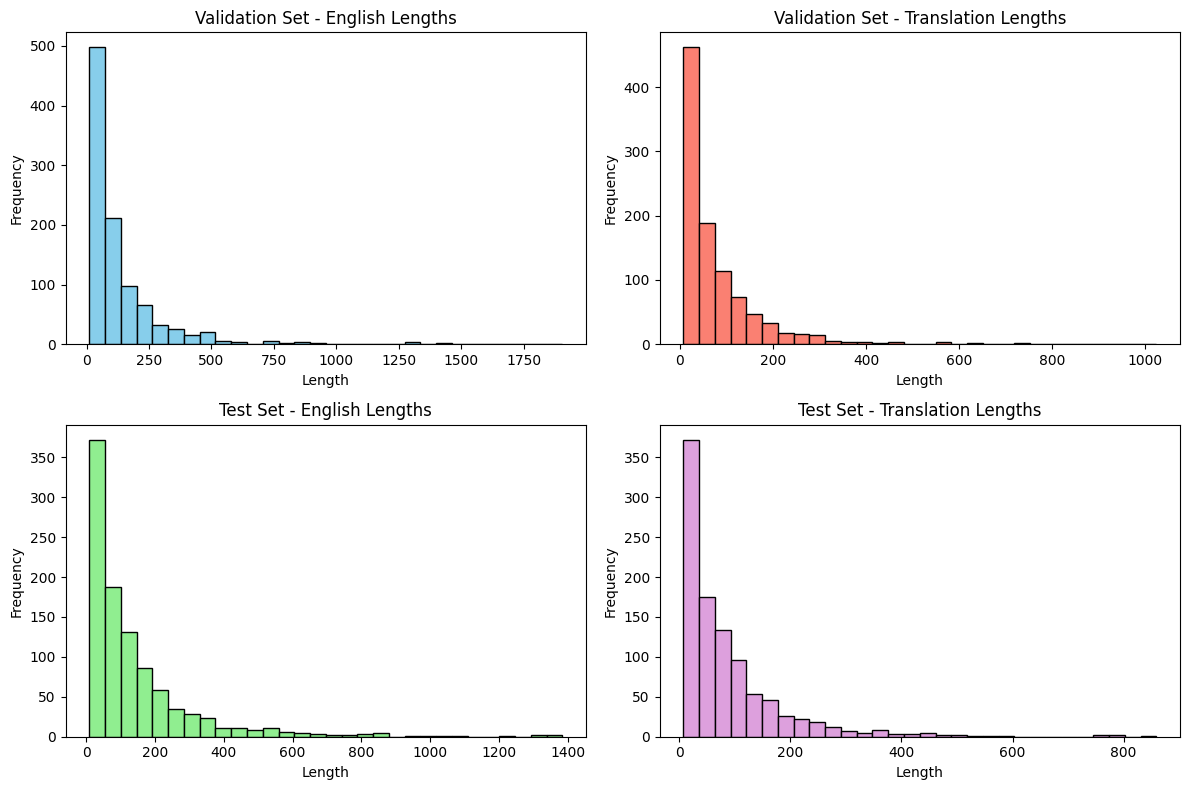

In [7]:
import matplotlib.pyplot as plt

# Compute lengths
len_val = [(len(row['en']), len(row['tr'])) for idx, row in new_val_data.iterrows()]
len_test = [(len(row['en']), len(row['tr'])) for idx, row in new_test_data.iterrows()]

# Split into separate lists
val_en_lens = [en for en, tr in len_val]
val_tr_lens = [tr for en, tr in len_val]
test_en_lens = [en for en, tr in len_test]
test_tr_lens = [tr for en, tr in len_test]

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Validation set
axs[0, 0].hist(val_en_lens, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Validation Set - English Lengths')
axs[0, 0].set_xlabel('Length')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(val_tr_lens, bins=30, color='salmon', edgecolor='black')
axs[0, 1].set_title('Validation Set - Translation Lengths')
axs[0, 1].set_xlabel('Length')
axs[0, 1].set_ylabel('Frequency')

# Test set
axs[1, 0].hist(test_en_lens, bins=30, color='lightgreen', edgecolor='black')
axs[1, 0].set_title('Test Set - English Lengths')
axs[1, 0].set_xlabel('Length')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(test_tr_lens, bins=30, color='plum', edgecolor='black')
axs[1, 1].set_title('Test Set - Translation Lengths')
axs[1, 1].set_xlabel('Length')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import ks_2samp

# Kolmogorov-Smirnov test between validation and test sets
ks_en = ks_2samp(val_en_lens, test_en_lens)
ks_tr = ks_2samp(val_tr_lens, test_tr_lens)

# Display results
print("Kolmogorov-Smirnov Test Results:")
print("-" * 40)
print(f"EN lengths - D-statistic: {ks_en.statistic:.4f}, p-value: {ks_en.pvalue:.4f}")
if ks_en.pvalue < 0.05:
    print("🟥 Significant difference in EN distributions (p < 0.05)")
else:
    print("🟩 No significant difference in EN distributions")

print("-" * 40)
print(f"TR lengths - D-statistic: {ks_tr.statistic:.4f}, p-value: {ks_tr.pvalue:.4f}")
if ks_tr.pvalue < 0.05:
    print("🟥 Significant difference in TR distributions (p < 0.05)")
else:
    print("🟩 No significant difference in TR distributions")


Kolmogorov-Smirnov Test Results:
----------------------------------------
EN lengths - D-statistic: 0.0520, p-value: 0.1339
🟩 No significant difference in EN distributions
----------------------------------------
TR lengths - D-statistic: 0.0630, p-value: 0.0378
🟥 Significant difference in TR distributions (p < 0.05)


### Checking to see if there is overlap in the test/val with train skewing the results

In [45]:
# Check for overlapping English phrases
train_en_set = set(train_data['en'].str.strip().str.lower())
val_en_set = set(val_data['en'].str.strip().str.lower())
test_en_set = set(test_data['en'].str.strip().str.lower())

# Check for overlapping Akkadian phrases
train_tr_set = set(train_data['tr'].str.strip().str.lower())
val_tr_set = set(val_data['tr'].str.strip().str.lower())
test_tr_set = set(test_data['tr'].str.strip().str.lower())

# Intersections
val_en_overlap = train_en_set.intersection(val_en_set)
test_en_overlap = train_en_set.intersection(test_en_set)

val_tr_overlap = train_tr_set.intersection(val_tr_set)
test_tr_overlap = train_tr_set.intersection(test_tr_set)

# Results
print(f"🔍 English Overlap: val/train = {len(val_en_overlap)}, test/train = {len(test_en_overlap)}")
print(f"🔍 Akkadian Overlap: val/train = {len(val_tr_overlap)}, test/train = {len(test_tr_overlap)}")

# Optional: Print a few examples if overlap is found
if val_en_overlap:
    print("\n⚠️ Overlapping English examples (val/train):")
    for ex in list(val_en_overlap)[:5]:
        print(" -", ex)

if test_en_overlap:
    print("\n⚠️ Overlapping English examples (test/train):")
    for ex in list(test_en_overlap)[:5]:
        print(" -", ex)


🔍 English Overlap: val/train = 0, test/train = 0
🔍 Akkadian Overlap: val/train = 0, test/train = 0


In [10]:
# Enhanced Data Leakage Detection + Automatic Cleanup

# Check for overlapping English phrases
train_en_set = set(train_data['en'].str.strip().str.lower())
val_en_set = set(val_data['en'].str.strip().str.lower())
test_en_set = set(test_data['en'].str.strip().str.lower())

# Check for overlapping Akkadian phrases
train_tr_set = set(train_data['tr'].str.strip().str.lower())
val_tr_set = set(val_data['tr'].str.strip().str.lower())
test_tr_set = set(test_data['tr'].str.strip().str.lower())

# Check for overlapping complete pairs (English + Akkadian together)
train_pairs = set(zip(train_data['en'].str.strip().str.lower(),
                      train_data['tr'].str.strip().str.lower()))
val_pairs = set(zip(val_data['en'].str.strip().str.lower(),
                    val_data['tr'].str.strip().str.lower()))
test_pairs = set(zip(test_data['en'].str.strip().str.lower(),
                     test_data['tr'].str.strip().str.lower()))

# Individual language intersections
val_en_overlap = train_en_set.intersection(val_en_set)
test_en_overlap = train_en_set.intersection(test_en_set)
val_tr_overlap = train_tr_set.intersection(val_tr_set)
test_tr_overlap = train_tr_set.intersection(test_tr_set)

# Complete pair intersections
val_pair_overlap = train_pairs.intersection(val_pairs)
test_pair_overlap = train_pairs.intersection(test_pairs)

# ORIGINAL Results Summary
print("=" * 60)
print("🔍 ORIGINAL DATA LEAKAGE DETECTION RESULTS")
print("=" * 60)

print(f"\n📝 INDIVIDUAL LANGUAGE OVERLAPS:")
print(f"   English    → val/train = {len(val_en_overlap):3d}, test/train = {len(test_en_overlap):3d}")
print(f"   Akkadian   → val/train = {len(val_tr_overlap):3d}, test/train = {len(test_tr_overlap):3d}")

print(f"\n🔗 COMPLETE PAIR OVERLAPS:")
print(f"   Both langs → val/train = {len(val_pair_overlap):3d}, test/train = {len(test_pair_overlap):3d}")

# Severity assessment
total_issues = len(val_en_overlap) + len(test_en_overlap) + len(val_tr_overlap) + len(test_tr_overlap) + len(val_pair_overlap) + len(test_pair_overlap)

if total_issues == 0:
    print(f"\n✅ STATUS: CLEAN - No data leakage detected!")
else:
    print(f"\n⚠  STATUS: OVERLAP DETECTED - Will clean training data...")

# =============================================================================
# AUTOMATIC CLEANUP: Remove overlapping rows from training data
# =============================================================================

if total_issues > 0:
    print("\n" + "=" * 60)
    print("🧹 CLEANING TRAINING DATA")
    print("=" * 60)

    original_train_size = len(train_data)

    # Create normalized columns for matching
    train_data_clean = train_data.copy()
    train_data_clean['english_norm'] = train_data_clean['en'].str.strip().str.lower()
    train_data_clean['akkadian_norm'] = train_data_clean['tr'].str.strip().str.lower()

    # Collect all overlapping items to remove
    all_overlapping_english = val_en_overlap.union(test_en_overlap)
    all_overlapping_akkadian = val_tr_overlap.union(test_tr_overlap)
    all_overlapping_pairs = val_pair_overlap.union(test_pair_overlap)

    # Create boolean masks for rows to remove
    english_mask = train_data_clean['english_norm'].isin(all_overlapping_english)
    akkadian_mask = train_data_clean['akkadian_norm'].isin(all_overlapping_akkadian)

    # For complete pairs, create a combined mask
    pair_mask = pd.Series(False, index=train_data_clean.index)
    if all_overlapping_pairs:
        for en, ak in all_overlapping_pairs:
            pair_condition = (train_data_clean['english_norm'] == en) & (train_data_clean['akkadian_norm'] == ak)
            pair_mask = pair_mask | pair_condition

    # Combine all masks (remove if ANY overlap detected)
    rows_to_remove = english_mask | akkadian_mask | pair_mask

    # Apply the cleanup
    train_data_cleaned = train_data_clean[~rows_to_remove].drop(['english_norm', 'akkadian_norm'], axis=1)

    removed_count = original_train_size - len(train_data_cleaned)

    print(f"📊 Training data size: {original_train_size:,} → {len(train_data_cleaned):,}")
    print(f"🗑  Removed {removed_count:,} overlapping rows ({removed_count/original_train_size*100:.1f}%)")

    # Verify cleanup worked
    print(f"\n🔍 VERIFYING CLEANUP...")

    # Re-run detection on cleaned data
    train_en_clean = set(train_data_cleaned['en'].str.strip().str.lower())
    train_tr_clean = set(train_data_cleaned['tr'].str.strip().str.lower())
    train_pairs_clean = set(zip(train_data_cleaned['en'].str.strip().str.lower(),
                                train_data_cleaned['tr'].str.strip().str.lower()))

    # Check for remaining overlaps
    val_en_clean = train_en_clean.intersection(val_en_set)
    test_en_clean = train_en_clean.intersection(test_en_set)
    val_tr_clean = train_tr_clean.intersection(val_tr_set)
    test_tr_clean = train_tr_clean.intersection(test_tr_set)
    val_pair_clean = train_pairs_clean.intersection(val_pairs)
    test_pair_clean = train_pairs_clean.intersection(test_pairs)

    remaining_issues = len(val_en_clean) + len(test_en_clean) + len(val_tr_clean) + len(test_tr_clean) + len(val_pair_clean) + len(test_pair_clean)

    print(f"\n📝 CLEANED OVERLAPS:")
    print(f"   English    → val/train = {len(val_en_clean):3d}, test/train = {len(test_en_clean):3d}")
    print(f"   Akkadian   → val/train = {len(val_tr_clean):3d}, test/train = {len(test_tr_clean):3d}")
    print(f"   Both langs → val/train = {len(val_pair_clean):3d}, test/train = {len(test_pair_clean):3d}")

    if remaining_issues == 0:
        print(f"\n✅ SUCCESS: All overlaps removed!")
        print(f"💾 Use 'train_data_cleaned' for training")
    else:
        print(f"\n⚠  WARNING: {remaining_issues} overlaps still remain")

else:
    print(f"\n💾 No cleanup needed - use original 'train_data'")


🔍 ORIGINAL DATA LEAKAGE DETECTION RESULTS

📝 INDIVIDUAL LANGUAGE OVERLAPS:
   English    → val/train =   0, test/train =   0
   Akkadian   → val/train =   0, test/train =   0

🔗 COMPLETE PAIR OVERLAPS:
   Both langs → val/train =   0, test/train =   0

✅ STATUS: CLEAN - No data leakage detected!

💾 No cleanup needed - use original 'train_data'


## Pre-processing

In [4]:
# Here, we have sentence pairs
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [5]:
def tokenize_function(examples, max_len=200):
    eos_token_id = tokenizer.eos_token_id

    # Tokenize inputs and labels first, without padding
    inputs = tokenizer(
        examples["tr"],
        truncation=True,
        max_length=max_len,
        padding=False
    )["input_ids"]

    labels = tokenizer(
        examples["en"],
        truncation=True,
        max_length=max_len,
        padding=False
    )["input_ids"]

    inputs_with_eos = [seq + [eos_token_id] if eos_token_id not in seq else seq for seq in inputs]
    labels_with_eos = [seq + [eos_token_id] if eos_token_id not in seq else seq for seq in labels]

    # Pad
    padded_inputs = tokenizer.pad(
        {"input_ids": inputs_with_eos},
        padding="max_length",
        max_length=max_len,
        return_attention_mask=True
    )
    padded_labels = tokenizer.pad(
        {"input_ids": labels_with_eos},
        padding="max_length",
        max_length=max_len
    )

    input_ids = padded_inputs["input_ids"]
    attention_mask = padded_inputs["attention_mask"]
    label_ids = padded_labels["input_ids"]

    return {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": label_ids
    }


## Load previous model

In [19]:
model_checkpoint = "models/research_label_smoothing_after_200_lr_scheduler"
tokenizer_checkpoint = "models/research_label_smoothing_after_200_lr_scheduler"

from transformers import MarianConfig

config = MarianConfig.from_pretrained(model_checkpoint)
# config.dropout= 0.3
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

In [7]:
tokenizer_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"
model_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"

from transformers import MarianConfig

config = MarianConfig.from_pretrained(model_checkpoint_old)
# config.dropout= 0.3
# config.attention_dropout = 0.2
# config.activation_dropout = 0.2
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint_old)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint_old, config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

## tokenize data

In [8]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']
        self.labels = tokenized_data['labels']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


train_loader = DataLoader(CustomDataset(tokenized_train), batch_size=8, shuffle=True)
valid_loader = DataLoader(CustomDataset(tokenized_val), batch_size=64)
test_loader = DataLoader(CustomDataset(tokenized_test), batch_size=64)

Map:   0%|          | 0/31256 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

### Plot csv accuracies 

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_and_print_final_accuracies(directory):
    plt.figure(figsize=(10, 6))

    dataset_sizes = [3000 * (i + 1) for i in range(6)]  # [3000, 6000, ..., 18000]
    csv_files = sorted([f for f in os.listdir(directory) if f.endswith(".csv")])

    print("Final Validation Accuracies:")
    for file, size in zip(csv_files, dataset_sizes):
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        if "Validation Accuracy" in df.columns:
            plt.plot(df.index, df["Validation Accuracy"], label=f"Data {size}")
            final_acc = df["Validation Accuracy"].iloc[-1]
            print(f"Data {size}: {final_acc:.2f}%")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Validation Accuracy Across Dataset Sizes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_and_print_final_accuracies("/kaggle/working/my_data")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/my_data'

<Figure size 1000x600 with 0 Axes>

### save_model_test

In [17]:
def save_model(model, tokenizer, optimizer, dataset_id):
    import os
    import json
    import torch

    save_path = "models/" + dataset_id
    os.makedirs(save_path, exist_ok=True)

    # Save model and tokenizer
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # Save optimizer state only
    torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pt"))


In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)
save_model(model, tokenizer, optimizer, "temp")

/home/mamdouh/anaconda3/envs/test/lib/python3.10/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


### save_results_csv_test

In [16]:

import pandas as pd
import os
import json

def save_training_results(train_losses, val_losses, train_accuracies, val_accuracies, extension_name, output_dir="./results", create=False):
    """
    Saves training and validation metrics to a CSV file with a custom extension.
    If the file exists, appends new rows to it.
    """
    # Use local directory instead of Kaggle paths

    filename = os.path.join(output_dir, f"results_{extension_name}.csv")

    # Determine starting epoch number
    starting_epoch = 1

    if not create and os.path.exists(filename):
        # Check existing file for epoch count

        print("Checking existing file for epoch count...")
        existing_df = pd.read_csv(filename)
        if len(existing_df) > 0:
            starting_epoch = existing_df['Epoch'].max() + 1


    # Create DataFrame for new results with continuous epoch numbering
    new_results_df = pd.DataFrame({
        "Epoch": list(range(starting_epoch, starting_epoch + len(train_losses))),
        "Train Loss": train_losses,
        "Train Accuracy": train_accuracies,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies
    })


    if create or not os.path.exists(filename):
        # Creating new file - just use new results
        combined_df = new_results_df
    else:
        # Append to existing data
        try:
            existing_df = pd.read_csv(filename)
            # Simply concatenate - no need to check for duplicates since we're using continuous numbering
            combined_df = pd.concat([existing_df, new_results_df], ignore_index=True)

        except Exception as e:
            combined_df = new_results_df

    # Save the combined DataFrame
    combined_df.to_csv(filename, index=False)

    return filename

## model_training

In [12]:
# name = "research_smrt_paraphraser"
name = "research_label_smoothing_after_50_lr_scheduler"

In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)
# optimizer.load_state_dict(torch.load(f"models/{name}/optimizer.pt"))
class DelayedScheduler:
    """Wrap any scheduler so .step() is a no‑op for the first N epochs."""
    def __init__(self, inner, delay):
        self.inner = inner
        self.delay = delay
        self.epoch = 0

    def step(self, metric):
        if self.epoch >= self.delay:
            self.inner.step(metric)
        self.epoch += 1

base_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=3, min_lr=1e-7, verbose=True
)
scheduler = DelayedScheduler(base_sched, delay=50)



In [52]:
new_lr = 1e-6
for pg in optimizer.param_groups:
    pg['lr'] = new_lr

In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_freq = 2
num_epochs = 10
print()
# Double-check it's correct
pad_token_id = tokenizer.pad_token_id
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        labels = batch['labels']

        # Compute loss ignoring pad tokens
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=pad_token_id,
            reduction='mean',
            label_smoothing = 0.1
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()

        # Compute accuracy ignoring pad tokens
        _, predicted = torch.max(logits, dim=-1)
        active_positions = (labels != -100) & (labels != pad_token_id)
        train_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
        train_total += active_positions.sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch + 1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch['labels']

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=pad_token_id,
                reduction='mean'
            )
            val_loss += loss.item()

            _, predicted = torch.max(logits, dim=-1)
            active_positions = (labels != -100) & (labels != pad_token_id)
            val_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
            val_total += active_positions.sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")

    if (epoch+1) % save_freq == 0:
        # save_model(model, tokenizer, optimizer, name)
        # save_training_results(train_losses,val_losses, train_accuracies, val_accuracies, extension_name=name)
        train_losses = []
        val_losses = []

        train_accuracies = []

        val_accuracies = []




Training Epoch 1:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.4611, Train Accuracy = 55.23%


Validation Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: Validation Loss = 1.6702, Validation Accuracy = 66.51%


Training Epoch 2:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.7659, Train Accuracy = 68.05%


Validation Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: Validation Loss = 1.3770, Validation Accuracy = 72.03%


Training Epoch 3:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.5268, Train Accuracy = 73.00%


Validation Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: Validation Loss = 1.2443, Validation Accuracy = 74.58%


Training Epoch 4:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.3778, Train Accuracy = 76.22%


Validation Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: Validation Loss = 1.1660, Validation Accuracy = 76.14%


Training Epoch 5:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.2728, Train Accuracy = 78.56%


Validation Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: Validation Loss = 1.1200, Validation Accuracy = 77.31%


Training Epoch 6:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.1892, Train Accuracy = 80.44%


Validation Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: Validation Loss = 1.0862, Validation Accuracy = 78.25%


Training Epoch 7:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.1175, Train Accuracy = 82.10%


Validation Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: Validation Loss = 1.0661, Validation Accuracy = 78.66%


Training Epoch 8:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.0601, Train Accuracy = 83.47%


Validation Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: Validation Loss = 1.0486, Validation Accuracy = 79.23%


Training Epoch 9:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.0076, Train Accuracy = 84.75%


Validation Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: Validation Loss = 1.0378, Validation Accuracy = 79.69%


Training Epoch 10:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 10: Train Loss = 1.9624, Train Accuracy = 85.84%


Validation Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: Validation Loss = 1.0396, Validation Accuracy = 80.13%


In [36]:
save_model(model, tokenizer, optimizer, name)
save_training_results(train_losses,val_losses, train_accuracies, val_accuracies, extension_name=name)


'./results/results_research_label_smoothing_after_200_lr_scheduler_extra_100.csv'

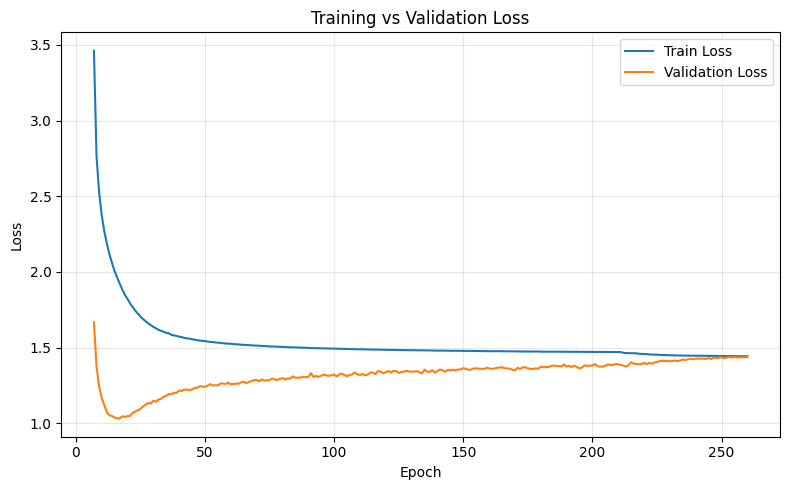

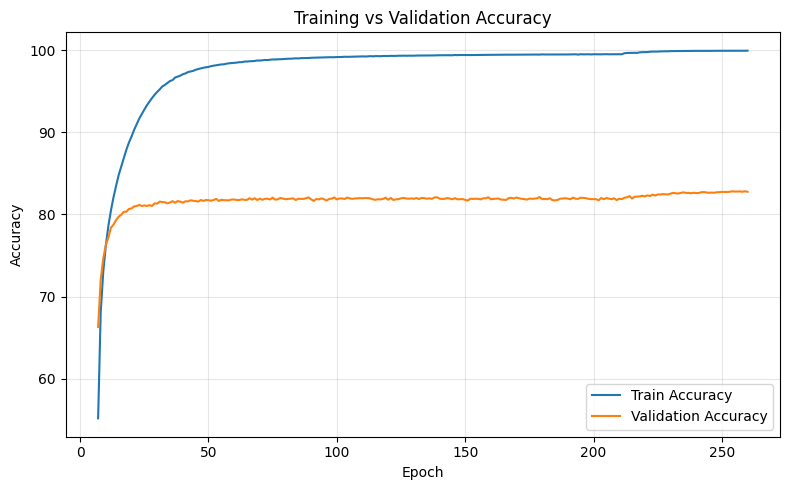

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1) Load CSV ===
# Change this to your file path if needed
csv_path = "results/results_research_label_smoothing_after_200_lr_scheduler.csv"
df = pd.read_csv(csv_path)

# --- Normalize column names (handles spaces/case/underscores) ---
def norm(s): return s.strip().lower().replace(" ", "_")
df.columns = [norm(c) for c in df.columns]

# Try common column name variants
def pick(*cands):
    for c in cands:
        if c in df.columns:
            return c
    raise KeyError(f"None of {cands} found in columns: {list(df.columns)}")

epoch_col = pick("epoch", "epochs")
train_loss_col = pick("train_loss", "training_loss")
val_loss_col   = pick("validation_loss", "valid_loss", "val_loss")
train_acc_col  = pick("train_accuracy", "training_accuracy", "train_acc")
val_acc_col    = pick("validation_accuracy", "valid_accuracy", "val_accuracy", "val_acc")

# === 2) Plot LOSS ===
plt.figure(figsize=(8, 5))
plt.plot(df[epoch_col], df[train_loss_col], label="Train Loss")
plt.plot(df[epoch_col], df[val_loss_col],   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === 3) Plot ACCURACY ===
plt.figure(figsize=(8, 5))
plt.plot(df[epoch_col], df[train_acc_col], label="Train Accuracy")
plt.plot(df[epoch_col], df[val_acc_col],   label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Evaluation

### Accuracy score

In [11]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

def compute_accuracy(model, tokenizer, dataloader):
    padding_token_id = tokenizer.pad_token_id  # Define padding token ID
    model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_tokens = 0
    correct_tokens = 0

    for batch in tqdm(dataloader, desc="Evaluating Loss on Validation Set"):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            # Get model outputs (logits) for token prediction
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch["labels"]

            # Compute the cross-entropy loss between logits and ground truth labels
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),  # Flatten the logits
                labels.view(-1),  # Flatten the labels
                ignore_index=padding_token_id,  # Ignore padding tokens in the loss calculation
                reduction='mean',
                # label_smoothing = 0.1
            )
            total_loss += loss.item()

            # Get the predicted token IDs from the logits (not from generate())
            predicted = torch.argmax(logits, dim=-1)

            # Create mask to ignore padding tokens (padding_token_id) and special tokens like -100
            mask = (labels != -100) & (labels != padding_token_id)

            # Count correct predictions
            correct_tokens += ((predicted == labels) & mask).sum().item()
            total_tokens += mask.sum().item()

    # Calculate average loss and token-level accuracy
    avg_loss = total_loss / len(valid_loader)
    token_accuracy = 100 * correct_tokens / total_tokens

    print(f"Validation Loss = {avg_loss:.4f}")
    print(f"Token-Level Accuracy on Validation Set: {token_accuracy:.2f}%")

compute_accuracy(model, tokenizer, valid_loader)

Evaluating Loss on Validation Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.61it/s]

Validation Loss = 1.0396
Token-Level Accuracy on Validation Set: 80.13%


### BLEU Score

In [12]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sacrebleu import corpus_bleu
nltk.download('punkt')


torch.backends.cudnn.benchmark = True

def compute_bleu_score(model, tokenizer, dataloader):
    model.eval()
    model.to(device)
    preds_val = []
    refs_val = []


    for batch in tqdm(dataloader, desc="Evaluating on Validation Set"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            generated_tokens = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=200,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                # early_stopping=True,
                num_beams=6,
            )
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)
        preds_val.extend(decoded_preds)
        refs_val.extend(decoded_labels)
    # Compute BLEU
    bleu_score = corpus_bleu(preds_val, [refs_val])
    print("BLEU score:", bleu_score.score)

    return preds_val, refs_val

preds_val, refs_val = compute_bleu_score(model, tokenizer, valid_loader)



[nltk_data] Downloading package punkt to /home/mamdouh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Evaluating on Validation Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:00<00:00,  3.76s/it]

BLEU score: 40.24305098234911


### ROUGE Score

In [13]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Cmpute average ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

for pred, ref in zip(preds_val, refs_val):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1: {100 * sum(rouge1_scores)/len(rouge1_scores):.2f}")
print(f"ROUGE-2: {100 * sum(rouge2_scores)/len(rouge2_scores):.2f}")
print(f"ROUGE-L: {100 * sum(rougeL_scores)/len(rougeL_scores):.2f}")


ROUGE-1: 67.95
ROUGE-2: 51.72
ROUGE-L: 64.71


### BERT score

In [14]:
from bert_score import score as bert_score
import sacrebleu
P, R, F1 = bert_score(preds_val, refs_val, lang='en', rescale_with_baseline=True)
print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall: {R.mean().item():.4f}")
print(f"BERTScore F1 (bertBLEU): {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore Precision: 0.5623
BERTScore Recall: 0.5529
BERTScore F1 (bertBLEU): 0.5564


### ChrF

In [15]:
import sacrebleu
# Compute chrF using sacrebleu
chrf = sacrebleu.corpus_chrf(preds_val, [refs_val], beta = 2)
print(f"chrF score: {chrf.score:.4f}")

chrF score: 61.5195


### METEOR

In [16]:
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
# Ensure the number of predictions and references are the same
assert len(preds_val) == len(refs_val), "Mismatch in number of predictions and references."

# Compute METEOR scores for each pair
scores = [
    meteor_score([ref.split()], pred.split())
    for pred, ref in zip(preds_val, refs_val)
]

# Calculate the average METEOR score
average_score = sum(scores) / len(scores)
print(f"Average METEOR Score: {average_score:.4f}")


[nltk_data] Downloading package wordnet to /home/mamdouh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Average METEOR Score: 0.6082


### Sample translation

In [35]:
import random
from tqdm import tqdm

model.eval()
N = 1000  # Number of random samples to display
samples_collected = 0

print("\nRandom Sample Translations:\n" + "=" * 60)

for batch in tqdm(valid_loader, desc="Sampling Random Translations"):
    if random.random() > 0.5:
        continue

    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        generated_tokens = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_length=200,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            early_stopping=True
        )

    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)
    decoded_inputs = tokenizer.batch_decode(batch["input_ids"].cpu().numpy(), skip_special_tokens=True)

    # Shuffle to randomly pick examples within the batch
    paired = list(zip(decoded_inputs, decoded_preds, decoded_labels))
    random.shuffle(paired)

    for source, pred, ref in paired:
        print(f"🪶 Akkadian: {source}")
        print(f"🔹 Prediction: {pred}")
        print(f"✅ Ground Truth: {ref}")
        print("-" * 60)
        samples_collected += 1
        if samples_collected >= N:
            break

    if samples_collected >= N:
        break



Random Sample Translations:


Sampling Random Translations:   6%|▋         | 2/32 [00:01<00:19,  1.50it/s]

🪶 Akkadian: Alligi ša Bit-Adini akšud
🔹 Prediction: I conquered the city Almanda of Bīt-Adini
✅ Ground Truth: I conquered the city Yallgu Alligu of Bīt-Adini
------------------------------------------------------------
🪶 Akkadian: ša šumēl išdātīša rakis libba immer šalam mahrēti
🔹 Prediction: The base of the left is bound The heart of the ram is normal First extispicy
✅ Ground Truth: of the left is bound at its base The heart of the ram is normal First extispicy
------------------------------------------------------------
🪶 Akkadian: Imba-appa tartannu ittešunu gipiš ummān Tannanu tašlīšāni 10 rab kiṣir adi Nergal-naṣir Sute lā ādir tāhāz 80 līm ṣāb qašassu azmarānê 8 mē 50 ṣumbāte sisê ittešunu šunūte ana māssu Šumeri u Akkad ašpur rēṣūssu
🔹 Prediction: """To the land of Sumer and Akkad he Šutur-Naḫundu sent to his Marduk-apla-iddinas assistance Imbappa his field marshal together with the massed body of his troops Tannānu his third man ten unit commanders including Nergal-nāṣir a Sut

Sampling Random Translations:   9%|▉         | 3/32 [00:03<00:32,  1.11s/it]

🪶 Akkadian: gimir annâ ginâ ša Tukulti-Inurta ana Šarrat-nipha bēlat rabâte arkus ma lū šar lū rubê ša arkat elāšu ina muhhī araddi issu lib lū lā anaššar ma ša ginâ ilak il lā issalmu lā addan Aššur Šamaš Marduk Šarrat-nipha ikrib lā assanamme
🔹 Prediction: All this is the regular offering of Tukulti-Ninurta to Šarrat-nipha the great lady Who is either the king or the prince who comes up after it or adds it to a shall not be removed from it Whoever does not pay the regular offerings to the gods or only who does not pay the deities Aššur Šamaš Marduk and Šarrat-nipha will not hear your prayers
✅ Ground Truth: All this is the regular offering that Tukulti-Ninurta established for Šarrat-nipha the great mistress Whoever be it a king or a prince who rises to power after me should add to them but he should not take anything away from them Whoever does not fulfill and give the regular offerings the dues of the god Aššur Šamaš Marduk and Šarrat-nipha will not hear his prayers
----------------

Sampling Random Translations:  16%|█▌        | 5/32 [00:04<00:25,  1.06it/s]

🪶 Akkadian: rubâtu arkīti ina šar mār enūma bīssu šatti ātanah alāk labāriš anhūssa ēteneddišu mušarâ šiṭir šum u mušarâ šiṭir šum ša Sin-ahhe-eriba šar māssu Aššur ab ab bān amār šaman apšuš nīq aqqâ ittešunu mušarâ šiṭir šum altakan Aššur Mullissu ikrib ašmâ
🔹 Prediction: May a future ruler one of the kings my descendants renovate its dilapidated sections when that temple becomes dilapidated and old May he find an inscribed object bearing my name and an inscribed object bearing the name of Sennacherib king of Assyria the grandfather of the father who had engendered me and then anoint them with oil make an offering and place them with an inscribed object bearing his name rev 5 The god Aššur and the goddess Mullissu will then hear his prayers
✅ Ground Truth: May a future ruler one of the kings my descendants renovate its dilapidated sections when that house becomes dilapidated and old May he find an inscribed object bearing my name and an inscribed object bearing the name of Sennacheri

Sampling Random Translations:  19%|█▉        | 6/32 [00:06<00:27,  1.07s/it]

🪶 Akkadian: il ša šar kî ilti bēt šu hūd libba amāru
🔹 Prediction: I swear by the gods of the king that ever since I saw joy
✅ Ground Truth: By the gods of the king I have not seen joy since
------------------------------------------------------------
🪶 Akkadian: Nabium-kudurra-uṣur šar Babbili zānin Esaggil u Ezida mār kēnu ša Nabium-apla-uṣur šar Babbili anāku Ezida bīssa kēnu in qerba Barsip
🔹 Prediction: Nebuchadnezzar II king of Babylon the one who provides for Esagil and Ezida legitimate son of Nabopolassar king of Babylon am I Ezida the true house inside Borsippa
✅ Ground Truth: Nebuchadnezzar II king of Babylon the one who provides for Esagil and Ezida legitimate heir of Nabopolassar king of Babylon am I With regard to Ezida which is inside Borsippa I built it
------------------------------------------------------------
🪶 Akkadian: addūka u āl ammāte ša ahappi lū e nišunu
🔹 Prediction: Moreover whether they will destroy that city or
✅ Ground Truth: Also those cities which they 

Sampling Random Translations:  22%|██▏       | 7/32 [00:07<00:25,  1.02s/it]


KeyboardInterrupt: 

### Error Analysis

In [24]:
# 📦 Required imports
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import evaluate
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')

# Metrics from Hugging Face evaluate
chrf_metric = evaluate.load("chrf")
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")


def compute_scores(model, valid_loader, tokenizer, device, metric_name="bleu"):
    model.eval()
    model.to(device)

    individual_scores = []
    sample_data = []
    sample_idx = 0

    # For BLEU smoothing
    smoothing_function = SmoothingFunction().method1

    # Prepare for corpus-level BLEU
    all_preds_tokens = []
    all_refs_tokens = []

    all_preds = []
    all_refs = []

    for batch_idx, batch in enumerate(tqdm(valid_loader, desc=f"Evaluating with {metric_name.upper()}")):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            generated_tokens = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=200,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                early_stopping=True
            )

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_refs = tokenizer.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)
        decoded_inputs = tokenizer.batch_decode(batch["input_ids"].cpu().numpy(), skip_special_tokens=True)

        for i in range(len(decoded_preds)):
            pred = decoded_preds[i]
            ref = decoded_refs[i]

            # Tokenize
            pred_tokens = nltk.word_tokenize(pred)
            ref_tokens = nltk.word_tokenize(ref)

            all_preds_tokens.append(pred_tokens)
            all_refs_tokens.append([ref_tokens])

            all_preds.append(pred)
            all_refs.append(ref)

            # Compute individual score
            if metric_name == "bleu":
                score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothing_function)
            elif metric_name == "meteor":
                score = meteor_score([ref], pred)
            elif metric_name == "chrf":
                score = chrf_metric.compute(predictions=[pred], references=[ref])["score"] / 100
            elif metric_name == "rouge":
                score = rouge_metric.compute(predictions=[pred], references=[ref])["rougeL"] / 100
            elif metric_name == "bertscore":
                bert_res = bertscore_metric.compute(predictions=[pred], references=[ref], lang="en")
                score = np.mean(bert_res["f1"])
            else:
                raise ValueError(f"Unsupported metric: {metric_name}")

            pred_length = len(pred_tokens)
            ref_length = len(ref_tokens)
            input_length = len(nltk.word_tokenize(decoded_inputs[i]))

            sample_data.append({
                'sample_id': sample_idx,
                f'{metric_name}_score': score,
                'input_text': decoded_inputs[i],
                'predicted_text': pred,
                'reference_text': ref,
                'batch_idx': batch_idx,
                'pred_length': pred_length,
                'ref_length': ref_length,
                'input_length': input_length,
                'length_diff': abs(pred_length - ref_length)
            })

            individual_scores.append(score)
            sample_idx += 1

    # Compute corpus-level score
    if metric_name == "bleu":
        corpus_score = corpus_bleu(all_refs_tokens, all_preds_tokens, smoothing_function=smoothing_function)
    elif metric_name == "chrf":
        corpus_score = chrf_metric.compute(predictions=all_preds, references=all_refs)["score"] / 100
    elif metric_name == "rouge":
        corpus_score = rouge_metric.compute(predictions=all_preds, references=all_refs)["rougeL"] / 100
    elif metric_name == "meteor":
        corpus_score = np.mean([meteor_score([r], p) for r, p in zip(all_refs, all_preds)])
    elif metric_name == "bertscore":
        bert_res = bertscore_metric.compute(predictions=all_preds, references=all_refs, lang="en")
        corpus_score = np.mean(bert_res["f1"])
    else:
        raise ValueError(f"Unsupported metric: {metric_name}")

    print(f"\nCorpus {metric_name.upper()}: {corpus_score:.4f} | Mean Sentence {metric_name.upper()}: {np.mean(individual_scores):.4f}")

    return individual_scores, sample_data, corpus_score


[nltk_data] Downloading package punkt to /home/mamdouh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mamdouh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
def create_bins_and_analyze(scores, sample_data, metric_name, num_bins=10):
    score_array = np.array(scores)
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(score_array, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)

    df = pd.DataFrame(sample_data)
    df['bin_index'] = bin_indices
    df['bin_range'] = df['bin_index'].apply(lambda x: f"{bin_edges[x]:.2f}-{bin_edges[x+1]:.2f}")
    df_sorted = df.sort_values(f'{metric_name}_score', ascending=False).reset_index(drop=True)
    df_sorted['rank'] = df_sorted.index + 1
    return df_sorted, bin_edges, bin_indices

def visualize_score_distribution(scores, bin_edges, sample_data, metric_name):
    df = pd.DataFrame(sample_data)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{metric_name.upper()} Score Distribution Analysis', fontsize=16)

    # Histogram
    axes[0, 0].hist(scores, bins=bin_edges, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel(f'{metric_name.upper()} Score')
    axes[0, 0].set_ylabel('Number of Samples')
    axes[0, 0].set_title(f'Distribution of {metric_name.upper()} Scores')
    axes[0, 0].grid(True, alpha=0.3)

    mean_score = np.mean(scores)
    median_score = np.median(scores)
    axes[0, 0].axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.3f}')
    axes[0, 0].axvline(median_score, color='orange', linestyle='--', label=f'Median: {median_score:.3f}')
    axes[0, 0].legend()

    # Box plot
    axes[0, 1].boxplot(scores, vert=True)
    axes[0, 1].set_ylabel(f'{metric_name.upper()} Score')
    axes[0, 1].set_title(f'{metric_name.upper()} Score Box Plot')
    axes[0, 1].grid(True, alpha=0.3)

    # Score vs Ref Length
    if df['ref_length'].min() == df['ref_length'].max():
        df['ref_length'] += 1

    df['ref_len_bin'] = pd.cut(df['ref_length'], bins=10)
    grouped = df.groupby('ref_len_bin')[f'{metric_name}_score'].mean()
    bin_counts = df['ref_len_bin'].value_counts().sort_index()

    axes[1, 0].bar(range(len(grouped)), grouped.values,
                   tick_label=[f"{interval.left:.0f}-{interval.right:.0f}" for interval in grouped.index],
                   alpha=0.7, color='lightgreen', edgecolor='black')

    axes[1, 0].set_xlabel('Reference Length Range (tokens)')
    axes[1, 0].set_ylabel(f'Mean {metric_name.upper()} Score')
    axes[1, 0].set_title(f'{metric_name.upper()} Score vs Reference Length')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    for idx, (val, count) in enumerate(zip(grouped.values, bin_counts.values)):
        axes[1, 0].text(idx, val + 0.01, f'n={count}', ha='center', va='bottom', fontsize=8)

    # Length distribution in lowest bin
    if 'bin_index' in df.columns:
        lowest_bin = df[df['bin_index'] == 0]
    else:
        lowest_bin = pd.DataFrame()

    if len(lowest_bin) > 0:
        axes[1, 1].hist(lowest_bin['ref_length'], bins=15, alpha=0.7, color='salmon', edgecolor='black')
        axes[1, 1].set_xlabel('Reference Length (tokens)')
        axes[1, 1].set_ylabel('Number of Samples')
        score_min, score_max = bin_edges[0], bin_edges[1]
        axes[1, 1].set_title(f'Lowest {metric_name.upper()} Bin ({score_min:.2f}-{score_max:.2f})\nn={len(lowest_bin)})')
        mean_len = lowest_bin['ref_length'].mean()
        med_len = lowest_bin['ref_length'].median()
        axes[1, 1].axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
        axes[1, 1].axvline(med_len, color='orange', linestyle='--', label=f'Median: {med_len:.1f}')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'No samples in\nlowest bin', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title(f'Length Distribution for Lowest {metric_name.upper()} Bin')

    plt.tight_layout()
    plt.show()
    return fig

def analyze_worst_and_best_samples(df_sorted, metric_name, n_samples=5):
    """
    Prints overall statistics and the top/bottom n_samples by score.
    df_sorted must contain:
      - f"{metric_name}_score"
      - 'rank', 'input_text', 'reference_text', 'predicted_text'
    """
    col = f"{metric_name}_score"
    total = len(df_sorted)
    mean = df_sorted[col].mean()
    med  = df_sorted[col].median()
    std  = df_sorted[col].std()
    mn   = df_sorted[col].min()
    mx   = df_sorted[col].max()

    print("="*80)
    print(f"{metric_name.upper()} SCORE ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total samples: {total}")
    print(f"Mean {metric_name.upper():6s}: {mean:.4f}")
    print(f"Median {metric_name.upper():4s}: {med:.4f}")
    print(f"Std Dev {metric_name.upper():4s}: {std:.4f}")
    print(f"Min {metric_name.upper():7s}: {mn:.4f}")
    print(f"Max {metric_name.upper():7s}: {mx:.4f}")

    print(f"\n{'-'*80}")
    print(f"TOP {n_samples} BEST PERFORMING SAMPLES:")
    print(f"{'-'*80}")
    for i in range(min(n_samples, total)):
        row = df_sorted.iloc[i]
        print(f"\nRank {row['rank']} ({metric_name.upper()}: {row[col]:.4f})")
        print(f"Input    : {row['input_text'][:100]}...")
        print(f"Reference: {row['reference_text'][:100]}...")
        print(f"Predicted: {row['predicted_text'][:100]}...")

    print(f"\n{'-'*80}")
    print(f"TOP {n_samples} WORST PERFORMING SAMPLES:")
    print(f"{'-'*80}")
    for i in range(min(n_samples, total)):
        row = df_sorted.iloc[-(i+1)]
        print(f"\nRank {row['rank']} ({metric_name.upper()}: {row[col]:.4f})")
        print(f"Input    : {row['input_text'][:100]}...")
        print(f"Reference: {row['reference_text'][:100]}...")
        print(f"Predicted: {row['predicted_text'][:100]}...")


def analyze_length_correlation(df_sorted, metric_name):
    """
    Computes and prints correlation between score and various length metrics.
    """
    col = f"{metric_name}_score"
    print(f"\n{'-'*80}")
    print(f"LENGTH vs {metric_name.upper()} SCORE CORRELATIONS")
    print(f"{'-'*80}")
    for length_col in ['ref_length', 'pred_length', 'length_diff', 'input_length']:
        corr = df_sorted[col].corr(df_sorted[length_col])
        print(f"Corr({metric_name}, {length_col}): {corr:.4f}")


def print_bin_statistics(df_sorted, bin_edges, metric_name):
    """
    Prints per-bin stats for the specified metric.
    Requires 'bin_index' column in df_sorted.
    """
    col = f"{metric_name}_score"
    total = len(df_sorted)
    print(f"\n{'-'*80}")
    print(f"BIN STATISTICS FOR {metric_name.upper()}")
    print(f"{'-'*80}")
    for i in range(len(bin_edges) - 1):
        bin_df = df_sorted[df_sorted['bin_index'] == i]
        if len(bin_df) == 0:
            continue
        lo, hi = bin_edges[i], bin_edges[i+1]
        mean_bin = bin_df[col].mean()
        pct = len(bin_df) / total * 100
        print(f"\nBin {i+1}: [{lo:.2f}–{hi:.2f}]")
        print(f"  Samples   : {len(bin_df)}")
        print(f"  Mean Score: {mean_bin:.4f}")
        print(f"  % of total: {pct:.1f}%")


In [26]:
metric_name = "chrf"
# Example usage
scores, sample_data, corpus_score = compute_scores(model, valid_loader, tokenizer, device, metric_name=metric_name)

Evaluating with CHRF: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Corpus CHRF: 0.7026 | Mean Sentence CHRF: 0.6234


/tmp/ipykernel_4101/2466334817.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('ref_len_bin')[f'{metric_name}_score'].mean()



Corpus chrf: 0.7026 | Mean Sentence chrf: 0.6234


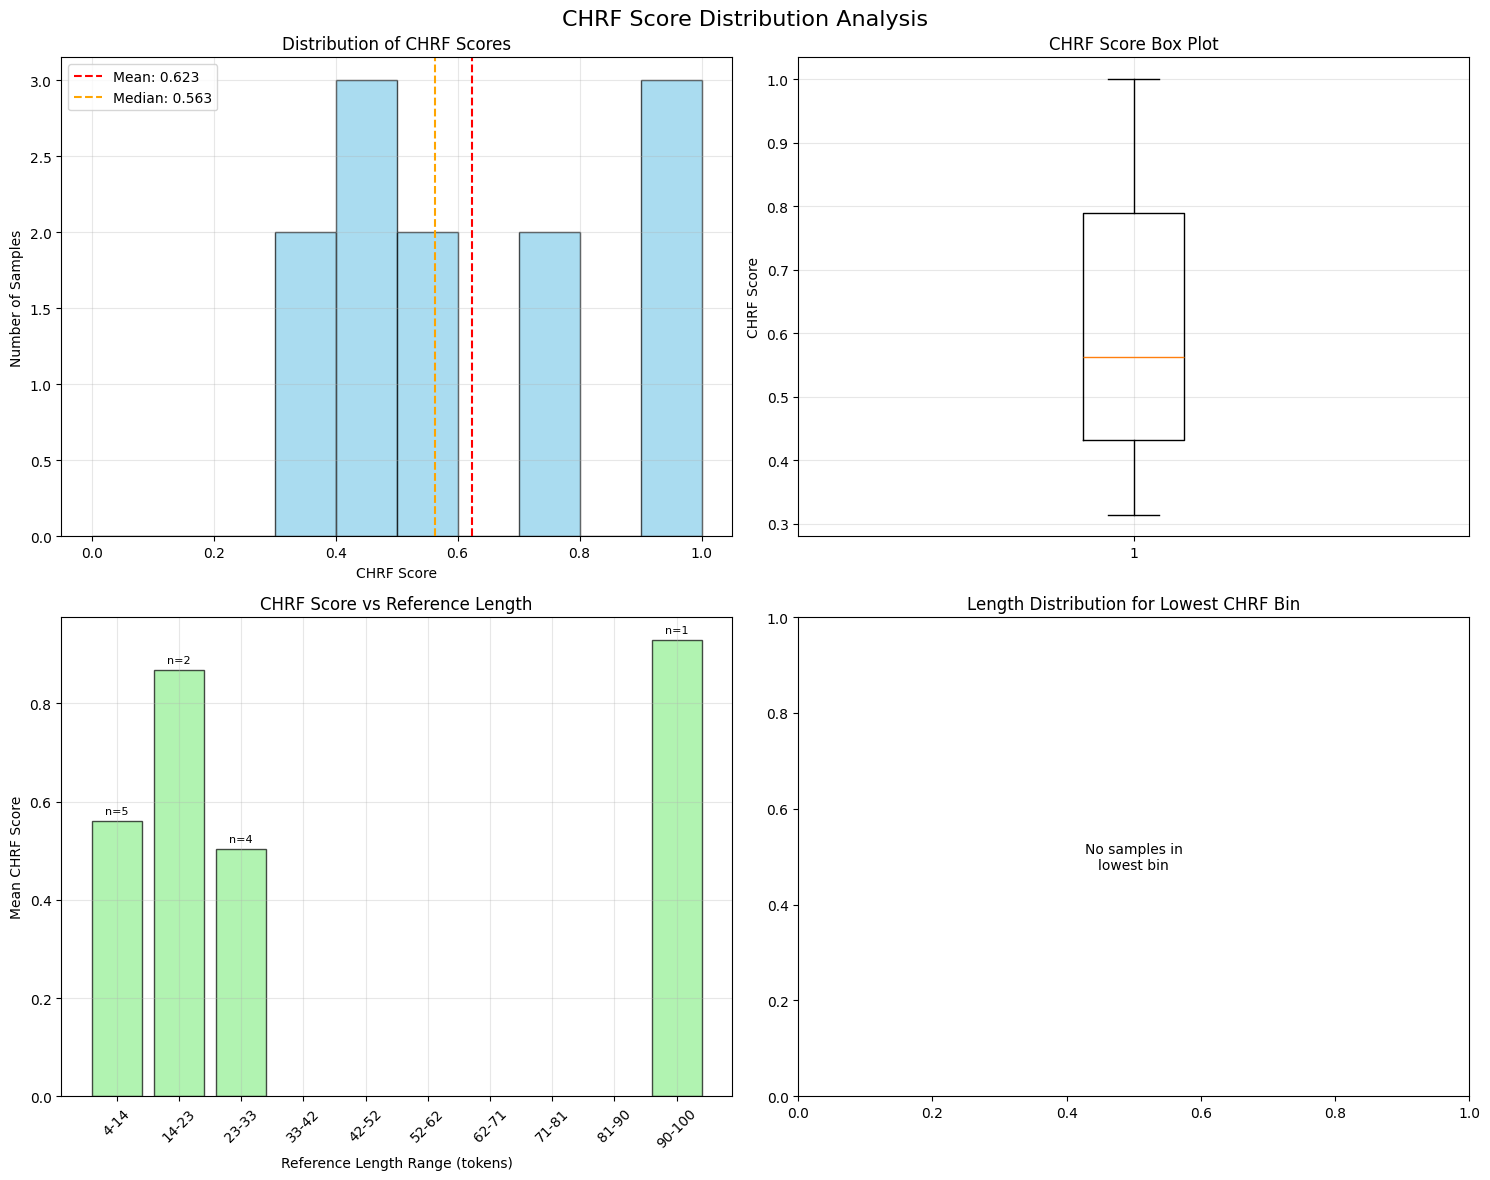

CHRF SCORE ANALYSIS SUMMARY
Total samples: 12
Mean CHRF  : 0.6234
Median CHRF: 0.5626
Std Dev CHRF: 0.2496
Min CHRF   : 0.3142
Max CHRF   : 1.0000

--------------------------------------------------------------------------------
TOP 5 BEST PERFORMING SAMPLES:
--------------------------------------------------------------------------------

Rank 1 (CHRF: 1.0000)
Input    : šumma ubān-hašê qablīt išdātīša muššur kaskāsu ebbet...
Reference: The base of the middle finger of the lung is loose The breast-bone is thick...
Predicted: The base of the middle finger of the lung is loose The breast-bone is thick...

Rank 2 (CHRF: 0.9826)
Input    : ina šamê azziz...
Reference: stands in the sky...
Predicted: — stands in the sky...

Rank 3 (CHRF: 0.9292)
Input    : Kalha mahrâ ša Salmani-ašared šar māssu Aššur rubā ālik pān epāš āl šū ānah aṣlul āl šū ana eššūte a...
Reference: "As for the ancient city Kalḫu which Shalmaneser I king of Assyria a ruler who had come before me ha...
Predicted: As for 

In [27]:
print(f"\nCorpus {metric_name}: {corpus_score:.4f} | Mean Sentence {metric_name}: {np.mean(scores):.4f}")

df_sorted, bin_edges, bin_indices = create_bins_and_analyze(scores, sample_data, metric_name=metric_name)
fig = visualize_score_distribution(scores, bin_edges, df_sorted, metric_name=metric_name)
analyze_worst_and_best_samples(df_sorted, metric_name=metric_name, n_samples=5)
analyze_length_correlation(df_sorted, metric_name=metric_name)
print_bin_statistics(df_sorted, bin_edges, metric_name=metric_name)


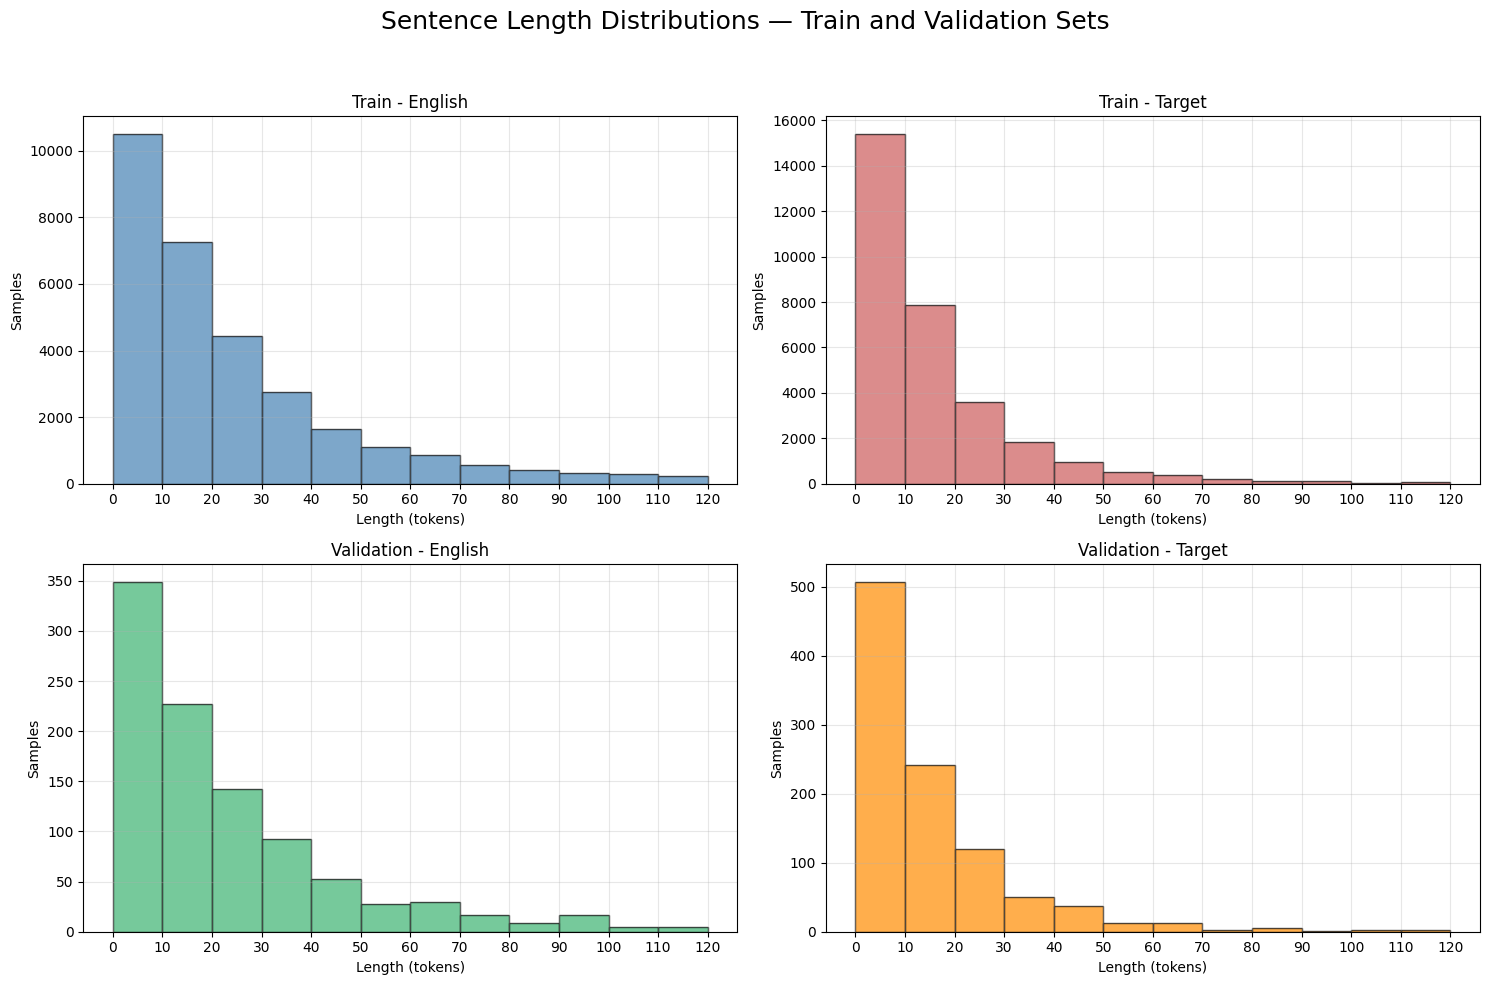

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Compute token lengths
train_data['en_length'] = train_data['en'].apply(lambda x: len(str(x).split()))
train_data['tr_length'] = train_data['tr'].apply(lambda x: len(str(x).split()))
val_data['en_length'] = val_data['en'].apply(lambda x: len(str(x).split()))
val_data['tr_length'] = val_data['tr'].apply(lambda x: len(str(x).split()))

# Define consistent bins for all
bins = np.arange(0, 125, 10)

# Create subplots (separate axes for train vs val)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentence Length Distributions — Train and Validation Sets', fontsize=18)

# Train - English
axes[0, 0].hist(train_data['en_length'], bins=bins, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Train - English')
axes[0, 0].set_xlabel('Length (tokens)')
axes[0, 0].set_ylabel('Samples')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(bins)

# Train - Target
axes[0, 1].hist(train_data['tr_length'], bins=bins, color='indianred', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Train - Target')
axes[0, 1].set_xlabel('Length (tokens)')
axes[0, 1].set_ylabel('Samples')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(bins)

# Val - English
axes[1, 0].hist(val_data['en_length'], bins=bins, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Validation - English')
axes[1, 0].set_xlabel('Length (tokens)')
axes[1, 0].set_ylabel('Samples')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(bins)

# Val - Target
axes[1, 1].hist(val_data['tr_length'], bins=bins, color='darkorange', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Validation - Target')
axes[1, 1].set_xlabel('Length (tokens)')
axes[1, 1].set_ylabel('Samples')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(bins)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


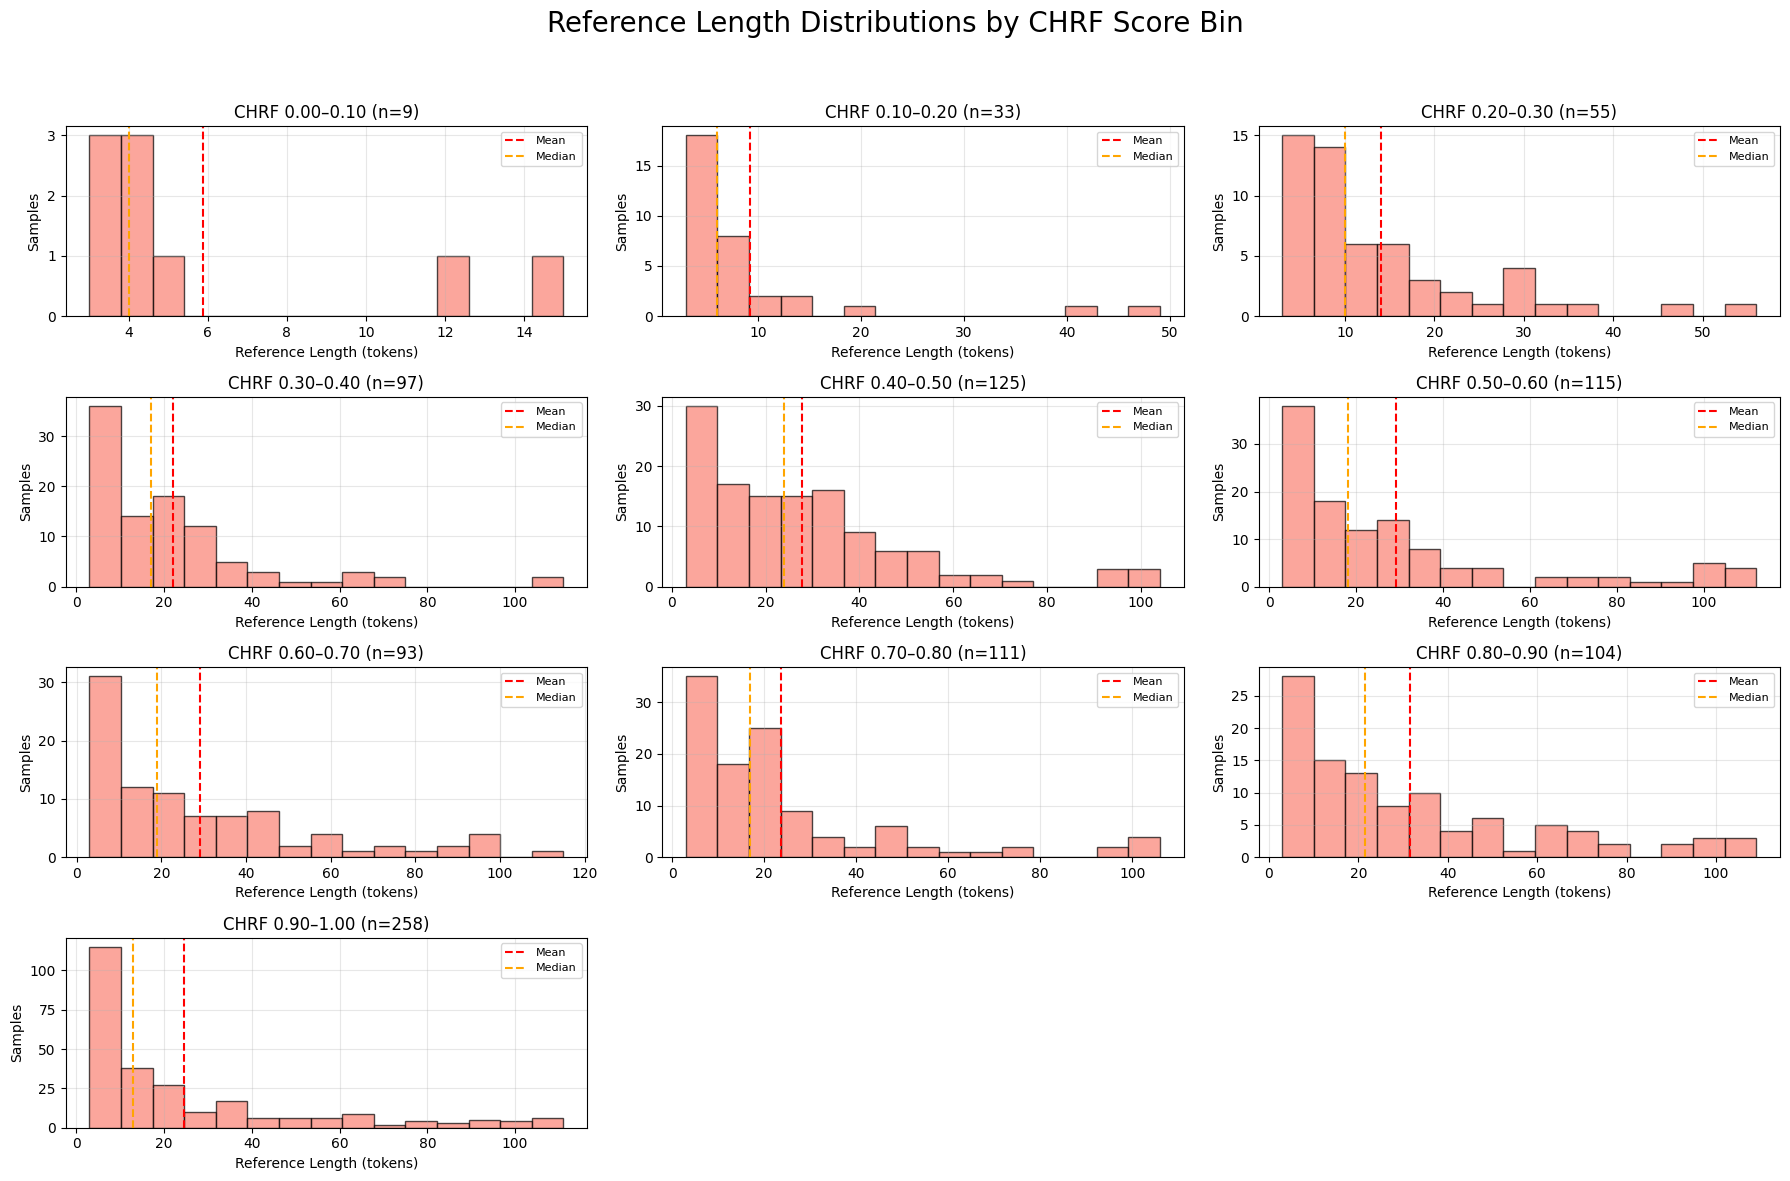

In [64]:
import matplotlib.pyplot as plt

def plot_ref_length_distributions_per_metric_bin(df_sorted, bin_edges, metric_name):
    """
    Plots the distribution of reference lengths for each metric score bin (default: 10 bins).
    The metric name is used for titles and labels.
    """
    num_bins = len(bin_edges) - 1
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    fig.suptitle(f'Reference Length Distributions by {metric_name.upper()} Score Bin', fontsize=20)

    for i in range(num_bins):
        row, col = divmod(i, 3)
        ax = axes[row, col]

        bin_samples = df_sorted[df_sorted['bin_index'] == i]

        if len(bin_samples) > 0:
            ax.hist(bin_samples['ref_length'], bins=15, alpha=0.7, color='salmon', edgecolor='black')
            ax.set_title(f'{metric_name.upper()} {bin_edges[i]:.2f}–{bin_edges[i+1]:.2f} (n={len(bin_samples)})')
            ax.set_xlabel('Reference Length (tokens)')
            ax.set_ylabel('Samples')
            ax.axvline(bin_samples['ref_length'].mean(), color='red', linestyle='--', label='Mean')
            ax.axvline(bin_samples['ref_length'].median(), color='orange', linestyle='--', label='Median')
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No samples', ha='center', va='center')
            ax.set_title(f'{metric_name.upper()} {bin_edges[i]:.2f}–{bin_edges[i+1]:.2f} (n=0)')

        ax.grid(True, alpha=0.3)

    # Hide unused subplots (if fewer than 12 bins)
    for j in range(num_bins, 12):
        row, col = divmod(j, 3)
        axes[row, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_ref_length_distributions_per_metric_bin(df_sorted, bin_edges, "chrf")

In [30]:
df_sorted.sort_values(by=f'{metric_name}_score', ascending=True)

,sample_id,chrf_score,input_text,predicted_text,reference_text,batch_idx,pred_length,ref_length,input_length,length_diff,bin_index,bin_range,rank,cosine_score
11,8,0.314164,a-a lū 02 šiqilšu,should either two or two shekels of,each or 2 shekels each,0,7,5,4,2,3,0.30-0.40,12,0.854077
10,3,0.323435,ṣāb ša bīrāt alāk erab,The men of the fort have come and entered,Let the garrison troops come and enter the gar...,0,9,9,5,0,3,0.30-0.40,11,0.612952
9,11,0.412778,šar ša dumāqī in muhhašu ašši unīqāti iqallū M...,The king who brings the jewellery on his behal...,The king who wears his jewelry and roasts youn...,0,36,26,21,10,4,0.40-0.50,10,0.787856
8,10,0.437119,ša ina pān akalla,who in my presence,whom I have detained in my presence,0,4,7,4,3,4,0.40-0.50,9,0.523491
7,0,0.477405,addan hurāṣi alaqqi nuk kīmā dullaka ša Uṣur-a...,I told him As soon as the work on Uṣur-amāssu ...,After we have finished the work on Uṣur-amatsa...,0,33,27,20,6,4,0.40-0.50,8,0.640845
6,4,0.545221,gabbašunu essišunu kārāni ša šar bēl altapar s...,all with the ports of trade about which the ki...,I have received the horses from the chief of t...,0,27,28,15,1,5,0.50-0.60,7,0.856016
5,1,0.579933,kî šeʾa u ṣarpa šamna būl Šakkan u ṭābti ina B...,If barley and oil the cattle of Šakkan and you...,Just as grain and silver oil the cattle of Šak...,0,27,31,23,4,5,0.50-0.60,6,0.844853
4,9,0.735697,manâya hurāṣi sakri addan gaspu šalāssîšu ana ...,He shall give x mina of pure gold and shall re...,He shall pay 3 minas of pure gold and shall re...,0,18,18,9,0,7,0.70-0.80,5,0.815861
3,5,0.743229,in imni u šumēl ša bāb šummû,In the right and left of the gate,To the right and left of the gates burned,0,8,9,7,1,7,0.70-0.80,4,0.750215
2,2,0.929180,Kalha mahrâ ša Salmani-ašared šar māssu Aššur ...,As for the ancient city Kalḫu which Shalmanese...,"""As for the ancient city Kalḫu which Shalmanes...",0,99,100,66,1,9,0.90-1.00,3,0.964988


In [29]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

# 1) load your DataFrame

# 2) embed all predicted & reference texts
model = SentenceTransformer('all-MiniLM-L6-v2')

pred_texts = df_sorted['predicted_text'].tolist()
ref_texts  = df_sorted['reference_text'].tolist()

# get torch tensors of shape (N, D)
pred_emb = model.encode(pred_texts, convert_to_tensor=True)
ref_emb  = model.encode(ref_texts,  convert_to_tensor=True)

# 3) compute cosine similarities row-wise
#    (gives a 1D tensor of length N)
cos_scores = torch.nn.functional.cosine_similarity(pred_emb, ref_emb, dim=1)

# attach back to your df_sorted
df_sorted = df_sorted.copy()
df_sorted['cosine_score'] = cos_scores.cpu().numpy()

# 4) pick the four smallest bins
lowest_bins = sorted(df_sorted['bin_index'].unique())[:4]

# 5) filter & average
mask = df_sorted['bin_index'].isin(lowest_bins)
avg_cosine = df_sorted.loc[mask, 'cosine_score'].mean()

print(f"Average cosine‐score over bins {lowest_bins}: {avg_cosine:.4f}")


Average cosine‐score over bins [3, 4, 5, 7]: 0.7429


# Hyperparameter Tuning

In [ ]:
from bert_score import score as bert_score
from evaluate import load
bleu   = load("bleu")    # token-level BLEU
meteor = load("meteor")  # METEOR
chrf   = load("chrf")    # CHRF (character-level F-score)
bert  = load("bertscore")  # BERTScore

In [ ]:

import gc
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler
from tqdm import tqdm
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
import pandas as pd
import json
import os
import logging
from datetime import datetime
from optuna.exceptions import TrialPruned
from transformers import MarianConfig

# Evaluation metrics



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class HyperparameterTuner:
    def __init__(self, tokenized_train, tokenized_val, device, base_model_name,
                 tokenizer, results_dir="tuning_results", max_epochs=15):
        self.tokenized_train = tokenized_train
        self.tokenized_val = tokenized_val
        self.device = device
        self.base_model_name = base_model_name
        self.tokenizer = tokenizer
        self.results_dir = results_dir
        self.pad_token_id = tokenizer.pad_token_id
        self.max_epochs = max_epochs

        os.makedirs(results_dir, exist_ok=True)
        self.results = []
        self.csv_path = os.path.join(
            results_dir,
            f"tuning_results_{datetime.now():%Y%m%d_%H%M%S}.csv"
        )




    def objective(self, trial):
        self.history = []
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True),
            'weight_decay':  trial.suggest_float('weight_decay', 0.01, 0.2, log=True),
            'dropout':       trial.suggest_float('dropout', 0.1, 0.5),
            'attention_dropout':  trial.suggest_float('attention_dropout', 0.0, 0.3),
            'activation_dropout': trial.suggest_float('activation_dropout', 0.0, 0.3),
            'label_smoothing':    trial.suggest_float('label_smoothing', 0.05, 0.2),
            'batch_size':         trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
            'warmup_ratio':       trial.suggest_float('warmup_ratio', 0.0, 0.1),
        }

        logger.info(f"[Trial {trial.number}] Params: {params}")

        self.train_loader = DataLoader(CustomDataset(self.tokenized_train), batch_size=params["batch_size"], shuffle=True)
        self.valid_loader = DataLoader(CustomDataset(self.tokenized_val), batch_size=params["batch_size"], shuffle=True)

        try:
            best_val, train_acc, val_acc, metrics= self.train_model(params, trial)
            trial.set_user_attr("bleu", metrics["bleu"])
            trial.set_user_attr("meteor", metrics["meteor"])
            trial.set_user_attr("chrf", metrics["chrf"])
            trial.set_user_attr("bert", metrics["bert"])
        except TrialPruned:
            history = self.history
            # Grab the latest recorded history entry (the last epoch you ran)
            last = history[-1]
            # Build a “pruned” result dict (you can customize which fields you want)
            pruned_result = {
                'trial':         trial.number,
                'best_val_acc':  max(h['val_acc'] for h in history),
                'final_train_acc': last['train_acc'],
                'final_val_acc':   last['val_acc'],
                **params,
                'pruned':        True,
                'pruned_epoch':  last['epoch'],
                'training_history': history,
                'timestamp':     datetime.now().isoformat()
            }
            self.results.append(pruned_result)
            self.save_results()
            # re-raise so Optuna correctly marks it as pruned
            raise

        # if we get here, the trial wasn’t pruned
        result = {
            'trial':         trial.number,
            'best_val_acc':  best_val,
            'final_train_acc': train_acc,
            'final_val_acc':   val_acc,
            **params,
            **metrics,
            'pruned':        False,
            'training_history': self.history,
            'timestamp':     datetime.now().isoformat()
        }
        self.results.append(result)
        self.save_results()
        return best_val


    def compute_metrics(self, model, tokenizer, dataloader):
        model.eval()
        model.to(device)
        preds_val = []
        refs_val = []


        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                generated_tokens = model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    max_length=200,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                    early_stopping=True,
                )
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)
            preds_val.extend(decoded_preds)
            refs_val.extend(decoded_labels)
        # Compute BLEU
        predictions = preds_val
        references = refs_val
        bleu_result   = bleu.compute(predictions=predictions, references=references)['bleu']
        meteor_result = meteor.compute(predictions=predictions, references=references)['meteor']
        chrf_result   = chrf.compute(predictions=predictions, references=references)['score']
        bert_result = np.mean(bert.compute(predictions=predictions, references=references, lang='en', rescale_with_baseline=True)['f1'])
        return {"bleu": bleu_result, "meteor": meteor_result, "chrf": chrf_result, "bert": bert_result}

    def train_model(self, params, trial):
        # reload fresh model each trial
        config = MarianConfig.from_pretrained(self.base_model_name)
        config.dropout = params['dropout']
        config.attention_dropout = params['attention_dropout']
        config.activation_dropout = params['activation_dropout']
        model = AutoModelForSeq2SeqLM.from_pretrained(self.base_model_name, config=config)

        model.to(self.device)

        optimizer = AdamW(model.parameters(),
                          lr=params['learning_rate'],
                          weight_decay=params['weight_decay'])
        total_steps = self.max_epochs * len(self.train_loader)
        scheduler = get_scheduler("linear", optimizer,
                                  num_warmup_steps=int(total_steps * params['warmup_ratio']),
                                  num_training_steps=total_steps)
        best_val_acc = 0.0

        for epoch in range(1, self.max_epochs + 1):
            # ----- TRAIN -----
            model.train()
            t_loss = t_corr = t_total = 0
            for batch in self.train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                out = model(**batch)
                logits = out.logits
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    batch['labels'].view(-1),
                    ignore_index=self.pad_token_id,
                    label_smoothing=params['label_smoothing']
                )
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                t_loss += loss.item()
                preds = logits.argmax(-1)
                mask = (batch['labels'] != -100) & (batch['labels'] != self.pad_token_id)
                t_corr += (preds[mask] == batch['labels'][mask]).sum().item()
                t_total += mask.sum().item()

            train_acc = 100 * t_corr / t_total

            # ----- VALIDATION -----
            model.eval()
            v_loss = v_corr = v_total = 0
            with torch.no_grad():
                for batch in self.valid_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    logits = model(**batch).logits
                    loss = F.cross_entropy(
                        logits.view(-1, logits.size(-1)),
                        batch['labels'].view(-1),
                        ignore_index=self.pad_token_id
                    )
                    v_loss += loss.item()
                    preds = logits.argmax(-1)
                    mask = (batch['labels'] != -100) & (batch['labels'] != self.pad_token_id)
                    v_corr += (preds[mask] == batch['labels'][mask]).sum().item()
                    v_total += mask.sum().item()


            val_acc = 100 * v_corr / v_total

            # **Update best & log**
            if val_acc > best_val_acc:
                best_val_acc = val_acc

            logger.info(
                f"Trial {trial.number} | Epoch {epoch:02d} | "
                f"train_acc={train_acc:.2f}%  val_acc={val_acc:.2f}%"
            )

            self.history.append({
                'epoch': epoch,
                'train_loss': t_loss / len(self.train_loader),
                'val_loss':   v_loss / len(self.valid_loader),
                'train_acc':  train_acc,
                'val_acc':    val_acc
            })


            # **Report & prune**
            trial.report(val_acc, epoch)
            if trial.should_prune():
                self._cleanup_gpu(model)
                raise optuna.exceptions.TrialPruned()
        metrics = self.compute_metrics(model, self.tokenizer, self.valid_loader)
        # metrics = {"bleu": 0.0, "meteor": 0.0, "chrf": 0.0, "bert": 0.0}  # Placeholder for metrics
        return best_val_acc, train_acc, val_acc, metrics


    def _apply_dropout_to_model(self, model, params):
        for m in model.modules():
            if hasattr(m, 'dropout') and hasattr(m.dropout, 'p'):
                name = m.__class__.__name__.lower()
                if 'attention' in name:
                    m.dropout.p = params['attention_dropout']
                elif 'activation' in name:
                    m.dropout.p = params['activation_dropout']
                else:
                    m.dropout.p = params['dropout']

    def _cleanup_gpu(self, model):
        """Move everything off-GPU and free memory."""
        # 1) move model back to CPU
        model.to('cpu')

        # 2) delete references
        del model
        gc.collect()

        # 3) empty CUDA cache
        torch.cuda.empty_cache()
    def save_results(self):
        if not self.results:
            return
        # save CSV
        df = pd.DataFrame(self.results)
        df.to_csv(self.csv_path, index=False)
        logger.info(f"Saved CSV → {self.csv_path}")
        # detailed JSON
        detail = os.path.splitext(self.csv_path)[0] + "_detailed.json"
        with open(detail, "w") as f:
            json.dump(self.results, f, indent=2)
        logger.info(f"Saved JSON → {detail}")

    def create_study(self):
        study = optuna.create_study(
            direction='maximize',
            pruner=HyperbandPruner(min_resource=1,
                                   max_resource=self.max_epochs,
                                   reduction_factor=2),
            sampler=TPESampler(seed=42),
            storage="sqlite:///my_study.db",  # Save progress to this file!
            study_name="my_experiment",
        )
        self.study = study


    def load_study(self, study_name ="my_experiment", storage="sqlite:///my_study.db", timeout=None):
        study = optuna.load_study(
    study_name=study_name,
    storage=storage)
        self.study = study

    def optimize_study(self, n_trials=30, timeout=None):
        self.study.optimize(self.objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
        return self.study


# Usage:
tuner = HyperparameterTuner(tokenized_train, tokenized_val, device, "Helsinki-NLP/opus-mt-ROMANCE-en", tokenizer, max_epochs=32)
tuner._cleanup_gpu(model)
tuner.load_study()
# tuner.create_study()
study = tuner.optimize_study(n_trials = 100)
results = study.results


# Train on specific hyperparameters

In [61]:
# EXAMPLE params dictionary (already provided by you)
params = {
    "learning_rate": 9.330606024425662e-05,
    "weight_decay": 0.12106896936002161,
    "dropout": 0.18493564427131048,
    "attention_dropout": 0.05454749016213018,
    "activation_dropout": 0.055021352956030146,
    "label_smoothing": 0.09563633644393066,
    "batch_size": 32,
}


In [72]:
tokenizer_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"
model_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"
# model_checkpoint_old = "models/cloud_model"
# tokenizer_checkpoint_old = "models/cloud_model"
from transformers import MarianConfig

# config = MarianConfig.from_pretrained(model_checkpoint)
# config.dropout= 0.3
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint_old)
config = MarianConfig.from_pretrained(model_checkpoint_old)
config.dropout = params['dropout']
config.attention_dropout = params['attention_dropout']
config.activation_dropout = params['activation_dropout']
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint_old, config=config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

In [73]:
from torch.optim import AdamW
import torch.nn.functional as F

optimizer = AdamW(
    model.parameters(),
    lr=params.get("learning_rate", 5e-5),
    weight_decay=params.get("weight_decay", 0.01)
)
# optimizer.load_state_dict(torch.load("models/cloud_model/optimizer.pt"))



In [71]:
train_loader = DataLoader(CustomDataset(tokenized_train), batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(CustomDataset(tokenized_val), batch_size=params['batch_size'])

In [65]:
name = "cloud_model_2"
num_epochs = 100
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                          num_training_steps=40 * len(train_loader))

In [74]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_freq = 2
label_smoothing = params.get("label_smoothing", 0.0)

# 4. Training Loop
pad_token_id = tokenizer.pad_token_id
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    temp = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        labels = batch['labels']

        # Use label_smoothing from params
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=pad_token_id,
            reduction='mean',
            label_smoothing=label_smoothing
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()   # Uncomment if using scheduler

        train_loss += loss.item()

        # Compute accuracy ignoring pad tokens
        _, predicted = torch.max(logits, dim=-1)
        active_positions = (labels != -100) & (labels != pad_token_id)
        train_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
        train_total += active_positions.sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch + 1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch['labels']

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=pad_token_id,
                reduction='mean'
            )
            val_loss += loss.item()

            _, predicted = torch.max(logits, dim=-1)
            active_positions = (labels != -100) & (labels != pad_token_id)
            val_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
            val_total += active_positions.sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")

    if (epoch + 1) % save_freq == 0:
        save_model(model, tokenizer, optimizer, name)
        save_training_results(train_losses,val_losses, train_accuracies, val_accuracies, extension_name=name)
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []


Training Epoch 1:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.8921, Train Accuracy = 46.53%


Validation Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Validation Loss = 1.9561, Validation Accuracy = 60.64%


Training Epoch 2:   0%|          | 0/1189 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [70]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 9.330606024425662e-05
    maximize: False
    weight_decay: 0.12106896936002161
)